## Import packages

In [ ]:
import CairoMakie: activate!, Figure, Axis, save, lines!, scatter!, lines, scatter, scatterlines!, 
hlines!, vlines!, axislegend, Legend, series, series!, Theme, set_theme!, cgrad, band!, 
xlims!, ylims!, colgap!, rowgap!, arrows!, text!, GridLayout, rowsize!, colsize!, Relative, AxisAspect, 
density!, qqplot!, linkxaxes!, linkyaxes!, BBox, translate!, TopLeft, Label, resize_to_layout!,
hidexdecorations!, hideydecorations!, Inside, Outside, Aspect, Observable, notify

import Distributed: addprocs, pmap, @everywhere
import StatsBase: sample, mean, min, mode, fit, Histogram, std
import NaNStatistics: nanmean, nanstd, nansum, movmean
import DataFrames: DataFrame, insert!, select!, select
import JLD: save, load
import CSV: write, read, File
import LinearAlgebra: norm, dot, normalize!, normalize
using ProgressMeter
import Dates: now, Millisecond
import CurveFit: curve_fit, Polynomial
import Calculus: derivative
import Roots: find_zero, fzero, newton, Newton
#import ForwardDiff: derivative 
import NLsolve: nlsolve

#ENV["DATAFRAMES_ROWS"] = 5
import Plots: palette
c=palette(:default); c = [palette(:tab10)[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
#c=palette(:tab10); c = [c[1]; c[3]; c[4];c[5]; c[2]; [c[i] for i in 6:length(c)]]; #reorder colors
activate!() #activates the Makie backend
set_theme!(Theme(
    palette=(color = cgrad(c,length(c)),),
    Lines = (cycle = [:color],), 
    band = (cycle = [:color],),
    hlines = (cycle = [:color],),
    vlines = (cycle = [:color],),
    scatter = (cycle = [:color],),
    scatterlines = (cycle = [:color],),
    series = (cycle = [:color],),
    ))

In [2]:
findnearest(t::Number, A::AbstractArray) = findmin(abs.(A.-t))[2]; #find the position of t in A
findnearest(vec::AbstractArray, A::AbstractArray) = [findmin(abs.(A.-t))[2] for t in vec]; #find the positions of elements of vec in A

## Phase transition lines

In [3]:
dT = 0.001; Tblue_max = 0.5;
Tblue = dT:dT:Tblue_max;
Fblue(T) = T*acosh((1-T)/T);
ηblue = Fblue.(Tblue);
Tbluemax = Tblue[findmax(ηblue)[2]]; ηbluemax = findmax(ηblue)[1];

function find_redline(T)  
    fv(T, η, v) = -v + 0.5*sinh(2*v/T)/(cosh(2*v/T) + cosh(η/T));
    dfdv_v(T, x) = [fv(T, x[1], x[2])
                    derivative(v -> fv(T, x[1], v), x[2])];
    xguess(T) = [1-T, 0.5 - T/8];
    return T < 0.0029 ? NaN : try nlsolve(x -> dfdv_v(T, x), xguess(T)).zero[1] catch y NaN end
end

FV(    T, η, V) = 1/2*sinh(2*V/T) / (cosh(2*V/T) + cosh(η/T)) - V;
dFdV(  T, η, V) = derivative(V->FV(T, η, V), V)
d2FdV2(T, η, V) = derivative(V->dFdV(T, η, V), V)
d3FdV3(T, η, V) = derivative(V->d2FdV2(T, η, V), V)

function find_3crit_point()
    #T, eta, V
    find_3crit(x) = [FV(x[1], x[2], x[3]), dFdV(x[1], x[2], x[3]), d3FdV3(x[1], x[2], x[3])];
    xguess = [0.32, Fblue(0.32), 0];
    critpoint = nlsolve(x -> find_3crit(x), xguess).zero;  
    Tcritpoint=critpoint[1]; ηcritpoint=critpoint[2]; Vcritpoint=critpoint[3];
    return Tcritpoint, ηcritpoint
end
function find_redline_full(Tred)
    Tcritpoint = find_3crit_point()[1];
    dV_redcrit = 10^(-2);
    #red line
    dfdv_v_redcritline(T, x) = [FV(T, x[1], x[2]), dFdV(T, x[1], x[2])];
    xguess_redcritline1(T) = [find_redline(T), 0.5 - T/8];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline1(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];  Tsol = Tred; 
    Tsol, etasol, vsol = Tsol[vsol .> dV_redcrit], etasol[vsol .> dV_redcrit], vsol[vsol .> dV_redcrit];
    xguess_redcritline(T) = [find_redline(T), vsol[findnearest(T, Tsol)]];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];
    ηred = etasol;
    return ηred
end

Tcritpoint, ηcritpoint = find_3crit_point()
Tred = Tblue[0.003 .≤ Tblue .≤ Tcritpoint];
ηred = find_redline_full(Tred);
Tcritpoint, ηcritpoint 

(0.3333333346990391, 0.4389859650747112)

## Load IIM data from file

In [4]:
L = 40; # 40 10 100
IC = "ZERO"; #ZERO, RAND
ic = lowercase(IC);
file_name="./03_data_IIM_simulations/IIM1D_$(IC)_error_rt_vel_etas_0.0_1.0_Ts_0.01_0.85_bias_0.0_2.28_L_$(L)_iter_3000_234000"
df_raw = DataFrame(File(file_name*".csv"));
etas_raw = sort(unique(df_raw.eta));
Ts_raw   = sort(unique(df_raw.T)); 
df_raw = df_raw[(df_raw.eta .∈ Ref(etas_raw)) .&& (df_raw.T .∈ Ref(Ts_raw)), :];
println(names(df_raw))

["eta", "T", "bias", "error", "rt", "rt_cw", "rt_cor", "rt_error", "Vmode", "Vmean", "Vmode_cor", "Vmean_cor", "Vmode_error", "Vmean_error", "iterations"]


In [5]:
Tmax = 0.53; Tmin = 0.16; #cut low Ts where RT is too high (in the intermittent phase). Can be changed depending on the other parameters

ϵ1 = 0.01; 
error_rate = 0.3; errorbar = 0.02;  
dη = 0.02; etabar = 0.004;

df_error = df_raw[(df_raw.bias .== ϵ1) .& (abs.(df_raw.error .- error_rate) .< errorbar), :];
Ts_raw = sort(unique(df_error.T)); Ts_raw = Ts_raw[(Ts_raw .> Tmin) .& (Ts_raw .< Tmax)];
etas_raw = round.(vcat([mean(df_error[df_error.T .== T, :eta]) for T in Ts_raw]...), digits=2);

error_cont   = vcat([mean(df_raw[(abs.(df_raw.eta .- etas_raw[ind_T]       ) .< etabar) .& (df_raw.bias .== ϵ1) .& (df_raw.T .== T), :error]) for (ind_T, T) in enumerate(Ts_raw)]...);
errors_above = vcat([mean(df_raw[(abs.(df_raw.eta .- (etas_raw[ind_T] + dη)) .< etabar) .& (df_raw.bias .== ϵ1) .& (df_raw.T .== T), :error]) for (ind_T, T) in enumerate(Ts_raw)]...);
grad_error = (error_cont .- errors_above) ./ dη;
rt_cont  = vcat([mean(df_raw[(abs.(df_raw.eta .-  etas_raw[ind_T]      ) .< etabar) .& (df_raw.bias .== ϵ1) .& (df_raw.T .== T), :rt]) for (ind_T, T) in enumerate(Ts_raw)]...);
rt_above = vcat([mean(df_raw[(abs.(df_raw.eta .- (etas_raw[ind_T] + dη)) .< etabar) .& (df_raw.bias .== ϵ1) .& (df_raw.T .== T), :rt]) for (ind_T, T) in enumerate(Ts_raw)]...);
grad_rt = (rt_cont .- rt_above) ./ dη;

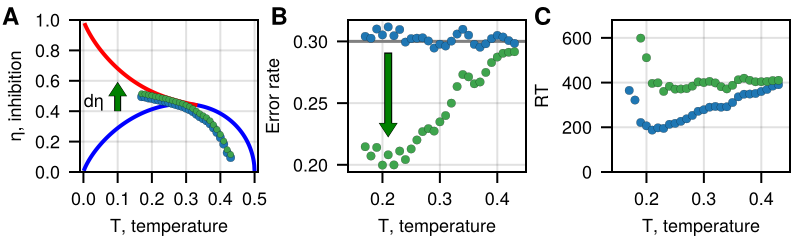

In [6]:
num_movmean=3;
fig = Figure(size=(400, 120), fontsize=9, figure_padding=(1, 5, 3, 1));  ax = []; 
begin
    if true
        ga = fig[1,1] = GridLayout();
        gb = fig[1,2] = GridLayout();
        gc = fig[1,3] = GridLayout();
        push!(ax, Axis(fig[1,1], xlabel="T, temperature", ylabel="η, inhibition", ));   
        push!(ax, Axis(fig[1,2], xlabel="T, temperature", ylabel="Error rate",    ));   
        push!(ax, Axis(fig[1,3], xlabel="T, temperature", ylabel="RT",            ));   

        lines!(ax[1], Tblue, ηblue, linewidth=2, color=:blue);  #  label="1-order tr-n", 
        lines!(ax[1], Tred,  ηred,  linewidth=2, color=:red );  #  label="2-order tr-n", 
        scatter!(ax[1], Ts_raw, movmean(etas_raw,       num_movmean), label="error rate = $(round(error_rate, digits=2))", markersize=6, strokewidth=0.1)
        scatter!(ax[1], Ts_raw, movmean(etas_raw .+ dη, num_movmean), label="η(error rate) + dη",                          markersize=4.5, strokewidth=0.1)

        hlines!(ax[2], [error_rate], color=:gray, linewidth=1.5)
        scatter!(ax[2], Ts_raw[.!isnan.(error_cont)],   movmean(error_cont[.!isnan.(error_cont)],     num_movmean), markersize=6, strokewidth=0.1)
        scatter!(ax[2], Ts_raw[.!isnan.(errors_above)], movmean(errors_above[.!isnan.(errors_above)], num_movmean), markersize=6, strokewidth=0.1)

        scatter!(ax[3], Ts_raw[.!isnan.(rt_cont)],  movmean(rt_cont[.!isnan.(rt_cont)],   num_movmean), markersize=6, strokewidth=0.1)
        scatter!(ax[3], Ts_raw[.!isnan.(rt_above)], movmean(rt_above[.!isnan.(rt_above)], num_movmean), markersize=6, strokewidth=0.1)
    end
    if true
        arrows!(ax[1], [0.1], [0.400], [0], [0.130], linecolor=:black, arrowcolor=:black, arrowsize=(13, 10), linewidth=3.5)
        arrows!(ax[1], [0.1], [0.402], [0], [0.128], linecolor=:green, arrowcolor=:green, arrowsize=(12, 9),  linewidth=2.5)
        arrows!(ax[2], [0.21], [0.291], [0], [-0.061], linecolor=:black, arrowcolor=:black, arrowsize=(13, 10), linewidth=4)
        arrows!(ax[2], [0.21], [0.290], [0], [-0.060], linecolor=:green, arrowcolor=:green, arrowsize=(12, 9),  linewidth=3)
        text!(ax[1], [0.03], [0.47], text="dη", fontsize=9, align=(:center,:center), color=:black)
    end
    if true
        [xlims!(axi,[-0.01, 0.51]) for axi in ax]; [axi.xticks=0:0.1:0.5 for axi in ax];
        ylims!(ax[1],[0, 1]); ax[1].yticks=0:0.2:1;
        #ax[3].yscale=log10;
        [xlims!(axi,[Tmin-0.02, 0.45]) for axi in ax[[2,3]]];
        ylims!(ax[3],[0, 680]); ax[3].yticks=0:200:2000;
    end
end
colgap!(fig.layout, 3); #rowgap!(fig.layout, 3)
for (label, layout) in zip(["A", "B", "C"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
            fontsize = 12,
            font = :bold,
            padding = (0, 30, -5, 0),
            halign = :right)
end
resize_to_layout!(fig)
fig